# Active Learning Demo - Efficient Training of a ML Model

Active learning is used to efficiently build a machine learning model. I test two machine learning algorithms - Gaussian process regression (GRP) and random forest (RF). By determining the uncertainty in each model's predictions and using a maximum uncertainty acquisition function, I can effectively build a machine learning model with fewer data points than a random sampling approach. Here, I use a custom dataset of van der Waals (vdW) heterostructure features and target properties that were generated through a high-throughput DFT workflow. More details on the materials and this dataset can be found in this notebook: [01-data_exploration.ipynb](https://github.com/dwillhelm/ActiveHetML/blob/main/notebooks/01-data_exploration.ipynb). 

In [3]:
# load some modules/packages
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb

from IPython.display import HTML, FileLink, display
from celluloid import Camera 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler 
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.metrics import mean_absolute_error, r2_score

from lolopy.learners import RandomForestRegressor

from plotters import plot_identity

# to load my custom vdW heterostructure dataset (uses custom package 'hetml' - not fully released/published)
from hetml.data.dataloaders import load_featureset, load_prediction_dataset

import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
warnings.simplefilter('ignore', category=FutureWarning)

## Prepare Dataset

The dataset is a custom dataset consisting of custom-built vdW heterostructure features/descriptors and several target properties (e.g., band gap energy, ionization energy, interlayer distance, etc.). VdW bilayer features are constructed by data-mining 2D monolayer properties and aggregating them into unique bilayer features. Target properties were determined using DFT.
 
A stacked ensemble regression model was trained on the original dataset consisting of ~800 DFT labeled materials, capable of predicting properties like the ionization energy (IE) with an MAE of 0.09 eV. The model was used to make predictions on over 6,000 unique bilayers. Here, I use those predictions as a toy dataset to demonstrate the capabilities of an active learning approach. 

In this notebook, I will bypass a few preprocessing steps because I am already familiar with this dataset and its features. Please refer to the notebook 01-data_exploration.ipynb for more details on these preprocessing steps. Please note that this is a personal dataset and it has not been fully released yet (I will release it when I’m finished with my dissertation) 



In [4]:
## load data, prepare data for pipeline ## 

# load the features/targets for predicting the ionization energy (IE)
TARGET = 'IE'
X0 ,_ , Xall   = load_featureset(target=TARGET)
targets = load_prediction_dataset(target=TARGET)

# get lasso coefs (from previous work)
fpath = f'../data/lasso_coefs/lasso_coefs_{TARGET}.csv'
coefs = pd.read_csv(fpath, index_col=0)

# prepare data
selected_feats = coefs.abs().iloc[:10].index.tolist()  # top 10 features only
y = pd.Series(data=targets.y_pred, index=targets.index)
X0 = X0.reindex(columns=selected_feats)
Xall = Xall.reindex(columns=selected_feats )
X = pd.concat((X0, Xall))
X = X.reindex(y.index)

# final features/targets
features = X.copy() 
targets  = y.copy() 
print(features.shape, targets.shape)

returning --> master | targets

Preprocessing Steps:
Feature Space Dim: (6332, 342)
Targets Dim: (790, 37)
	-building Anderson's Rule classes
	-building stacking configuration classes
	-using AUB bilayers, transforming to binary classes
	-dropping feature columns: (6332, 90)
	-dropping metal bilayers: (689, 37)
	-dropping Type III bilayers: (600, 37)
II    310
I     290
Name: band_alignment, dtype: int64
	-dropping bilayers w/ ILD < 2.5: (595, 37)
	-dropping bilayers w/ Eb > 40 meV: (595, 37)
	-dropping bilayers w/ charge transf. > 1 |e|: (595, 37)
	-one-hot-encod band alignment: (6332, 91)

Final --> Feature Space Dim: (6332, 91)
Final --> Targets Dim: (595, 37)

target = 'IE'  stacktype = 'AUB'
x dim: (595, 91)
y dim: (595,)
unlabeled-X dim: (5737, 91)


All Features (Pre-Feature Selection) (p=91):
['avg_gap_nosoc', 'avg_evac', 'avg_hform', 'avg_emass1', 'avg_emass2', 'avg_efermi_hse_nosoc', 'avg_cbm', 'avg_vbm', 'avg_excitonmass1', 'avg_excitonmass2', 'avg_alphax', 'avg_alphaz', 'av

## Active Learning via Gaussian Process Regression (GPR) and Random Forest (RF)

I compare the use of GPR and RF sequential learners against a random sequential selection. In active learning, the model uncertainty is used to choose the next data point from a pool of unknown materials. Algorithms such as GPR and RF provide a measure of uncertainty inherently.

###  Gaussian Process Regression (GPR)

At a high level, GPR is a supervised machine learning method that provides uncertainty estimation along with prediction values. GPR finds a distribution of functions that are consistent with a set of known data points. Generally speaking, GPR uses kernels to define a covariance matrix which can be used to sample smooth functions with nearby y’s for x’s that are similar, i.e. similar x’s will yield similar y’s. From the distribution of suitable functions, the mean and variance can be determined - providing the prediction and the uncertainty.

Here, I use the default RBF kernel. In GRP the kernel is a very important hyperparamter that need to be carefully selected. When working with small data, it is often difficult to tune hyperparamters without introducint sample bias. Generally, one might update hyperparameters as new data points are generated in a full active learning pipeline. From a Bayesian perspective, this distribution of functions provides a prior, which can be used to determine the posterior distribution. Using the Bayesian approach, the distribution of functions is updated new data points are considered - allowing for iterative optimization of your model.  

I choose this algorithm to test because GPR are one of the most commonly used algorithms in active learning. GPR are fairly versitile models capable of taking varying types of input values. However, GPR are oftentimes difficult to fit, kernel choice can be difficult, and do not scale efficeintly. 

#### Build GPR Pipeline 

Here I build a simple ML pipeline for a Gaussian process regression. The data is standardized by removing the mean and scaling to unit variance. Further details on the model can be found below. 

In [5]:


# preprocessing pipeline
num_features = X.columns.tolist() 
num_pipe = Pipeline(steps=[
    ('scale_features', StandardScaler() )
])

preprocessing_pipe = ColumnTransformer(transformers=[
    ('preprocessing_num', num_pipe, num_features)
])

# model/algo
model = GaussianProcessRegressor(alpha=1e-10) # using default kernel (RBF)

# full pipeline
pipe = Pipeline(steps=[
    ('preprocessing',   preprocessing_pipe), 
    ('model',           model)
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocessing_num',
                                                  Pipeline(steps=[('scale_features',
                                                                   StandardScaler())]),
                                                  ['max_vbm', 'avg_c_12',
                                                   'avg_cbm_d',
                                                   'avg_vbm_char_p',
                                                   'avg_lattice_param',
                                                   'avg_cbm',
                                                   'PymatgenData mean '
                                                   'mendeleev_no',
                                                   'PymatgenData std_dev '
                                                   'atomic_mass',
                                                   'avg_alphaz',
                                    

### RF   

Random Forest is an ensemble machine learning algorithm based on randomized decision trees. The ensemble of decision trees is constructed from bootstrap aggregation or “bagging”. Each tree uses a random set of data points sampled with replacement. The average value returned by each decision tree is used as the final prediction, and the variance between the predictions serves as the uncertainty. Here, I use the Lolo package by Citrine, which is an RF model which applies a bias correction to the jackknife variance estimate.  

Again, I use the default hyperparameters, but these could be iteratively optimized in a full active learning pipeline (e.g., using grid search or random search of hyperparameters). RF are generally roboust to the scale of the data, so I will bypass building a pipeline for this model. 

RF models are also very flexible models - able to capture nonlinear relationships in the data. Furthermore, these models offer more explainability compared to other models (such as feature importance). However, these models are prone to overfitting and can be difficult to tune as the many hyper parameters make it a relatively complex model. 


## Sequential Learning and Acquisition  Functions 
Knowledge of the uncertainty of a machine learning model has many advantages. It can be used to give the confidence in a model's prediction, where low confidence coils trigger the model to differ the decision to a real person. In active learning, the uncertainty of a prediction can be used to optimize a variable or train a model using fewer data points. Generally, the active learning loop is as follows: 

>1. Train a model with known data points
>2. Query pool of unlabeled data points for the next data point using acquisition functions 
>3. Label the new data point
>4. Append the new data point to the existing data
>5. Return to step (1). 

Models that provide uncertainty estimates are able to be used in an active learning loop. 

Choosing the next data point is done through “acquisition functions”. Here I use the maximum uncertainty (MU) acquisition function to efficiently train a machine learning algorithm. The MU is defined by:  

`x_new = argmax(var)`

where `x_new` is the new data point, and `var` is a list of uncertainty estimates for all unknown points. Intuitively, the MU acquisition function will select the data point the model is most uncertain of. By using these points, the model learns the underlying trends with fewer data points than via random selection. 

### Define Acquisition  Functions

Here I define four different acquisition functions: the maximum uncertainty (MU), maximum expected improvement (MEI), maximum likelihood improvement (MLI), and the upper confidence bound (UCB). In addition, I use a mixed acquisition method which first employs a MU to reduce the overall uncertainty of the model, and then employs a MIE to optimize the material property.

**MU:**  
This function queries the sample with the highest uncertainty.
<br>
$$ x^* = arg\_max \enspace \sigma[f(x_i)]$$
<br>

<br>

**MEI:**  
This approach takes the maximum value of the prediction of the model over the possible experiments to run.

<br>

$$ x^* = arg\_max \enspace E[f(x_i)]$$

<br>

**MLI:**  
This approach tells us that we are expecting to query a region for which we see an improvement and sufficient uncertainty to have a high likelihood of getting a larger value.

$$ x^* = arg\_max \enspace \frac{E[f(x_i)] - E[f(x_{best})]}{\sigma[f(x_i)]}$$

$x_{best}$ is the current best value in the training dataset.


**UCB:**  
This strategy queries the sample with the maximum value of its mean prediction plus its uncertainty.
<br>
$$ x^* = arg\_max \enspace [E[f(x_i)] + \sigma[f(x_i)]]$$
<br>

$x^*$ is the new sample pulled using the acquistion function.  
$\sigma$ is the standard deviation ($\sigma^2$ is the variance)  
$f(x_i)$ is the model and $x_i$ is a given predicted data point.  
$E[...]$ is the expected value.


In [6]:
## define some functions here

## acquistion functions

"""
The update functions follow this general format: 

Arguments: 
    y_pred (list, array, DataFrame): predicted values of y
    y_true (list, array, DataFrame): true value of y
    pool   (list): a list of training uids to be updated with the new seleciton

""" 

def update_random(y_pred, y_std, pool): 
    new_idx = y_pred.sample(n=1).index[0]
    pool.append(new_idx)
    return pool

def update_mu(y_pred, y_std, pool): 
    new_idx = y_std.idxmax() 
    pool.append(new_idx)
    return pool

def update_mei(y_pred, y_std, pool): 
    new_idx = y_pred.idxmax() 
    pool.append(new_idx)
    return pool

def update_mli(y_pred, y_std, pool): 
    ybest = y.loc[pool].max() 
    new_idx = ( (y_pred - ybest)/(y_std) ).idxmax()
    pool.append(new_idx)
    return pool

def update_ucb(y_pred, y_std, pool): 
    new_idx = (y_pred + y_std).idxmax()
    pool.append(new_idx)
    return pool

# active learning training - GPR
def train_activemodel_gpr(estimator, X, y, pool): 
    """Trains a GPR model using the current training pool data"""
    xtrain, xtest = X[X.index.isin(pool)], X[~X.index.isin(pool)]
    ytrain, ytest = y[y.index.isin(pool)], y[~y.index.isin(pool)]
    
    estimator.fit(xtrain, ytrain)
    y_pred, y_std = estimator.predict(xtest, **{'return_std': True})
    y_pred = pd.Series(y_pred, index=ytest.index)
    y_std  = pd.Series(y_std, index=ytest.index)
    return y_pred, y_std


# active learning training - RF
def train_activemodel_rf(X, y, pool): 
    """Trains a RF model using the current training pool data"""
    xtrain, xtest = X[X.index.isin(pool)], X[~X.index.isin(pool)]
    ytrain, ytest = y[y.index.isin(pool)], y[~y.index.isin(pool)]
    
    model = RandomForestRegressor() 
    model.fit(xtrain.to_numpy(), ytrain.to_numpy())
    y_pred, y_std = model.predict(xtest.to_numpy(), return_std=True)
    y_pred = pd.Series(y_pred, index=ytest.index)
    y_std  = pd.Series(y_std, index=ytest.index)
    return y_pred, y_std

def get_metrics(y_pred): 
    """returns the MAE and R2 score for a prediction"""
    y_true = y[y.index.isin(y_pred.index)]
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mae, r2





Some util functions

In [17]:
# util functions
def id_current_max(pool):
    """util function to identify the current best material found in the training pool"""
    ytrain = y.loc[pool]
    y_best_idx = ytrain.idxmax()  
    y_best     = ytrain.max() 
    return y_best, y_best_idx

def plot_parity(fig, ax, y_pred, pool, color):
    """util function to plot the pairity of two values""" 
    y_true = y[y.index.isin(y_pred.index)]

    ax.scatter(y_true, y_pred,ec='k',alpha=0.3,c=color)
    plot_identity(fig, ax, y_true, y_pred)
    ax.set_ybound(y.min()-1, y.max()+0.5)
    ax.set_xbound(y.min()-1, y.max()+0.5)
    ax.grid(True,alpha=0.1)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')   

### Build AML workflow

In [8]:
# setup data
X = features.copy() 
y = targets.copy() 

# identify global max 
global_max_idx = y.idxmax() 
global_max = y.max() 

# get inital pool of samples
starting_pool = X.sample(n=10).index.tolist() 
if global_max_idx in starting_pool: 
    starting_pool.remove(global_max_idx)

# setup staring pools for each method
idx_rand    = starting_pool.copy() 
idx_mu_gpr  = starting_pool.copy() 
idx_mu_rf   = starting_pool.copy() 

# setup visulization
fs = np.array([6.4,4.8])
fig, axes = plt.subplots(1,3,figsize=fs*1.5)
axes = axes.flatten() 
camera = Camera(fig)

n_iter = 400
res = [] 
for i in tqdm(range(n_iter)): 
    
    # random selection
    y_best, y_best_idx = id_current_max(idx_rand)
    y_pred, y_std = train_activemodel_gpr(pipe, X, y, idx_rand)
    idx_rand = update_random(y_pred, y_std, idx_rand)
    mae, r2 = get_metrics(y_pred)
    res.append([i, 'random', y_best, y_best_idx, len(idx_rand), mae, r2])

    if i%20 == 0: 
        ax = axes[0]
        plot_parity(fig, ax, y_pred, idx_rand, 'tab:blue')
        ax.text(3,7.5,f'Random:\nn={len(idx_rand)}\nR2:{r2:.2f}')
    
    # MU selection - GPR
    y_best, y_best_idx = id_current_max(idx_mu_gpr)
    y_pred, y_std = train_activemodel_gpr(pipe, X, y, idx_mu_gpr)
    idx_mu_gpr = update_mu(y_pred, y_std, idx_mu_gpr)
    mae, r2 = get_metrics(y_pred)
    res.append([i, 'mu-gpr', y_best, y_best_idx, len(idx_mu_gpr), mae, r2])

    if i%20 == 0: 
        ax = axes[1]
        plot_parity(fig, ax, y_pred, idx_mu_gpr, 'tab:orange')
        ax.text(3,7.5,f'GPR:\nn={len(idx_mu_gpr)}\nR2:{r2:.2f}')

    # MU selection - lolo RF 
    y_best, y_best_idx = id_current_max(idx_mu_rf)
    y_pred, y_std = train_activemodel_rf(X, y, idx_mu_rf)
    idx_mu_rf = update_mu(y_pred, y_std, idx_mu_rf)
    mae, r2 = get_metrics(y_pred)
    res.append([i, 'mu-rf', y_best, y_best_idx, len(idx_mu_rf), mae, r2 ])
    
    if i%20 == 0: 
        ax = axes[2]
        plot_parity(fig, ax, y_pred, idx_mu_rf, 'tab:green')
        ax.text(3,7.5,f'RF:\nn={len(idx_mu_rf)}\nR2:{r2:.2f}')
        camera.snap()

## visualize active learning ## 
from IPython.display import HTML 
animation = camera.animate() 
animation.save('./gif_active_learning_models.mp4')
plt.close()  

## convert results into dataframe
columns = ['step', 'method', 'y_best', 'y_best_idx', 'n_data', 'mae', 'r2']
res = pd.DataFrame(res,columns=columns)

100%|██████████| 400/400 [08:01<00:00,  1.20s/it]


## Results and Discussion

In [9]:
HTML(animation.to_html5_video())

In [10]:

# !!!! NOTICE: if video fails to render, please download the mp4 directly (or just look at repo README) !!! 

## load or render gif/mp4
local_file = FileLink('./gif_active_learning_models.mp4', result_html_prefix="Click here to download: ")
display(local_file)

/home/daniel/projects/vdw_project/ActiveHetML/notebooks/gif_active_learning_models.mp4

In [11]:
# display results as a table
res 

,step,method,y_best,y_best_idx,n_data,mae,r2
0,0,random,6.289305,huid-15448-AB,11,4.874488,-34.473525
1,0,mu-gpr,6.289305,huid-15448-AB,11,4.874488,-34.473525
2,0,mu-rf,6.289305,huid-15448-AB,11,0.441914,0.508954
3,1,random,6.289305,huid-15448-AB,12,4.801572,-33.560411
4,1,mu-gpr,6.768168,huid-5549-AA,12,4.769721,-33.234592
...,...,...,...,...,...,...,...
1195,398,mu-gpr,8.426877,huid-7007-AA,409,0.635350,0.059319
1196,398,mu-rf,8.426877,huid-7007-AA,409,0.087271,0.979603
1197,399,random,7.816143,huid-2404-AA,410,1.131300,-3.538781
1198,399,mu-gpr,8.426877,huid-7007-AA,410,0.635466,0.058470


### Learning Curves

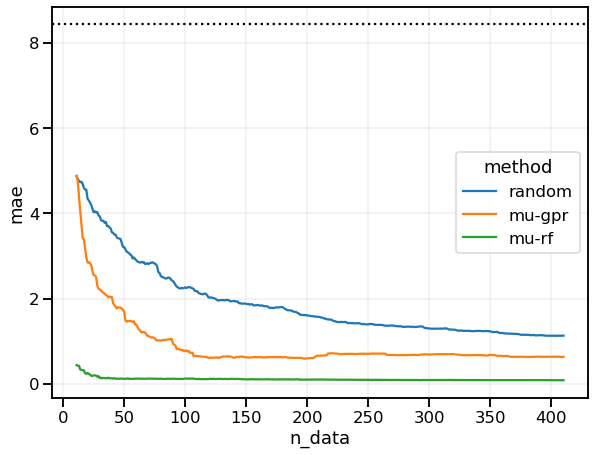

In [12]:
# plot learning curves (MAE) for each method - random, GPR, and RF. 

sb.set_context('talk')
fs = np.array([6.4,4.8])
fig, ax = plt.subplots(figsize=fs*1.5)
sb.lineplot(res.n_data, res.mae, hue=res.method, ax=ax)
ax.axhline(global_max, ls=':',c='k')
ax.grid(True, alpha=0.2)

<br>
<br>

**Learning Curves** 
In the figure shown above, we can see that the active learning approach can effectivly build an accurate ML model with significantly fewer data points. This can reduce the costs of performing experiments or computations. The RF model rapidly converges on a accurate model, followed by the GPR, and later the random selection. See the embedded figure in the [README](https://github.com/dwillhelm/ActiveHetML) for a video of 1000 iterations. 

In the [next Notebook](./04-bayesian_opt_IE.ipynb) I will demonstrate how active learning can be used to optimize a material property.   